In [1]:
from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
from scipy.ndimage.interpolation import zoom, rotate
import numpy as np
from tqdm import tqdm
%matplotlib inline
import keras
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
import keras.backend as K
from sklearn.utils.extmath import cartesian

Using TensorFlow backend.


In [2]:
TRAIN_DATA_DIR='./training/'
TEST_DATA_DIR='./test_set_images/'
NUM_TRAIN_FILES, NUM_TEST_FILES = 100, 50
IMG_SIZE, TEST_IMG_SIZE = 400, 608
PATCH_INPUT_SIZE = 96
PATCH_SIZE = 16
STEP_SIZE = 8
NUM_CLASSES = 2
RANDOM_SEED = 1337
BATCH_SIZE = 32

In [3]:
# Load data
X = np.zeros((NUM_TRAIN_FILES, IMG_SIZE, IMG_SIZE, 3))
for i in range(1, NUM_TRAIN_FILES+1):
    X[i-1] = mpimg.imread(TRAIN_DATA_DIR + "images/satImage_%.3d.png" % i)

Y = np.zeros((NUM_TRAIN_FILES, IMG_SIZE, IMG_SIZE))
for i in range(1, NUM_TRAIN_FILES+1):
    Y[i-1] = mpimg.imread(TRAIN_DATA_DIR + "groundtruth/satImage_%.3d.png" % i)
    
X_test = np.zeros((NUM_TEST_FILES, TEST_IMG_SIZE, TEST_IMG_SIZE, 3))
for i in range(1, NUM_TEST_FILES+1):
    X_test[i-1] = mpimg.imread(TEST_DATA_DIR + "test_%d/test_%d.png" % (i, i))
    
# Train/validate split
X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, test_size=0.1, random_state=RANDOM_SEED)
del X, Y

# Class weights for imbalanced data
num_ones, num_total = np.count_nonzero(Y_train > .5), Y_train.shape[0]*IMG_SIZE**2
class_weights = np.array([
    num_ones,
    num_total - num_ones,
]) / num_total

In [4]:
def input_pipeline_train(X, Y):
    x_padding = (int(np.ceil(np.sqrt(2))) * PATCH_INPUT_SIZE - PATCH_SIZE) // 2
    X_padded = np.zeros(X.shape + np.array([0, 2*x_padding, 2*x_padding, 0]))
    X_padded[:, x_padding:-x_padding, x_padding:-x_padding, :] = X
    
    y_padding = int(np.ceil(np.sqrt(2) - 1)) * PATCH_SIZE // 2
    Y_padded = np.zeros(Y.shape + np.array([0, 2*y_padding, 2*y_padding]))
    Y_padded[:, y_padding:-y_padding, y_padding:-y_padding] = Y
        
    X_batch = np.zeros((BATCH_SIZE, PATCH_INPUT_SIZE, PATCH_INPUT_SIZE, 3))
    Y_batch = np.zeros((BATCH_SIZE, NUM_CLASSES))
    batch_idx = 0
    
    indices = cartesian([
        np.arange(X.shape[0]), 
        np.arange(0, IMG_SIZE - PATCH_SIZE + 1, STEP_SIZE), 
        np.arange(0, IMG_SIZE - PATCH_SIZE + 1, STEP_SIZE)
    ])
        
    while True:
        np.random.shuffle(indices)
        
        for j in range(indices.shape[0]):
            i, y, x = indices[j]
        
            # Calculate maximum possible rotation at this place
            available_space = PATCH_SIZE + 2 * min(x, y, IMG_SIZE - x - PATCH_SIZE, IMG_SIZE - y - PATCH_SIZE)
            if available_space >= np.sqrt(2) * PATCH_SIZE:
                max_angle = 45
            else:
                max_angle = np.arcsin(available_space / np.sqrt(2) / IMG_SIZE) / np.pi * 360

            # Crop out patch with necessary padding p
            x_patch = X_padded[i, y:y+PATCH_SIZE+2*x_padding, x:x+PATCH_SIZE+2*x_padding]
            y_patch = Y_padded[i, y:y+PATCH_SIZE+2*y_padding, x:x+PATCH_SIZE+2*y_padding]

            # Rotate
            angle = np.random.rand() * max_angle
            x_patch = rotate(x_patch, angle, order=1, reshape=False)
            y_patch = rotate(y_patch, angle, order=1, reshape=False)

            # Crop back to desired patch size
            x_pad_delta = x_padding - (PATCH_INPUT_SIZE - PATCH_SIZE) // 2
            x_patch = x_patch[x_pad_delta:-x_pad_delta, x_pad_delta:-x_pad_delta]
            y_patch = y_patch[y_padding:-y_padding, y_padding:-y_padding]

            # Flip
            if np.random.rand() > .5:
                x_patch, y_patch = x_patch[::-1, :], y_patch[::-1, :]
            if np.random.rand() > .5:
                x_patch, y_patch = x_patch[:, ::-1], y_patch[:, ::-1]

            X_batch[batch_idx], Y_batch[batch_idx, 1] = x_patch, y_patch.mean()
            Y_batch[batch_idx, 0] = 1 - Y_batch[batch_idx, 1]
            batch_idx = (batch_idx + 1) % BATCH_SIZE
            if batch_idx == 0: 
                yield X_batch, Y_batch
                X_batch = np.zeros((BATCH_SIZE, PATCH_INPUT_SIZE, PATCH_INPUT_SIZE, 3))
                Y_batch = np.zeros((BATCH_SIZE, NUM_CLASSES))
                    
                    
def input_pipeline_test(X, Y, img_size):
    x_padding = (PATCH_INPUT_SIZE - PATCH_SIZE) // 2
    X_padded = np.zeros(X.shape + np.array([0, 2*x_padding, 2*x_padding, 0]))
    X_padded[:, x_padding:-x_padding, x_padding:-x_padding, :] = X

    X_batch = np.zeros((BATCH_SIZE, PATCH_INPUT_SIZE, PATCH_INPUT_SIZE, 3))
    Y_batch = np.zeros((BATCH_SIZE, NUM_CLASSES))
    batch_idx = 0
    
    while True:
        for i in range(X.shape[0]):
            for y in range(0, img_size - PATCH_SIZE + 1, PATCH_SIZE):
                for x in range(0, img_size - PATCH_SIZE + 1, PATCH_SIZE):
                    X_batch[batch_idx] = X_padded[i, y:y+PATCH_INPUT_SIZE, x:x+PATCH_INPUT_SIZE]
                    if Y is not None: 
                        Y_batch[batch_idx, 1] = Y[i, y:y+PATCH_SIZE, x:x+PATCH_SIZE].mean()
                        Y_batch[batch_idx, 0] = 1 - Y_batch[batch_idx, 1]

                    batch_idx = (batch_idx + 1) % BATCH_SIZE
                    if batch_idx == 0: 
                        if Y is not None: yield X_batch.copy(), Y_batch.copy()
                        else: yield X_batch.copy()

In [5]:
# Model definition
model = Sequential()

def conv(num_filters, **kwargs):
    model.add(Conv2D(num_filters, kernel_size=(3, 3), padding='same', **kwargs))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

# 96*96*3
conv(32, input_shape=(PATCH_INPUT_SIZE, PATCH_INPUT_SIZE, 3))
conv(32)
model.add(MaxPooling2D(pool_size=(2, 2)))
# 48*48*64
conv(64)
conv(64)
model.add(MaxPooling2D(pool_size=(2, 2)))
# 24*24*128
conv(128)
conv(128)
model.add(MaxPooling2D(pool_size=(2, 2)))
# 12*12*256
conv(256)
conv(256)
# 6*6*512
model.add(Flatten())
# 2048
model.add(Dense(2048))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
# 2048
model.add(Dense(1024))
model.add(BatchNormalization())
model.add(Activation('relu'))
# 512
model.add(Dense(NUM_CLASSES, activation='softmax'))

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def f1(y_true, y_pred):
    p, r = precision(y_true, y_pred), recall(y_true, y_pred)
    return 2 * p * r / (p + r)

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy', f1])

# Choose filename for saved models here
checkpoint = ModelCheckpoint('model8.{epoch:02d}-{val_acc:.4f}.hdf5', 
                             monitor='val_acc', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='max')

In [ ]:
# Train model
model.fit_generator(input_pipeline_train(X_train, Y_train),
          validation_data=input_pipeline_test(X_valid, Y_valid, img_size=IMG_SIZE),
          steps_per_epoch=X_train.shape[0] * (IMG_SIZE // STEP_SIZE - 1) ** 2 // BATCH_SIZE,
          validation_steps=X_valid.shape[0] * (IMG_SIZE // PATCH_SIZE) ** 2 // BATCH_SIZE,
          epochs=15,
          verbose=1,
          max_q_size=50,
          workers=4,
          pickle_safe=True,
          class_weight=class_weights,
          callbacks=[checkpoint])

In [113]:
# Restore model
# model.load_weights("model6.02-0.9593.hdf5")

In [ ]:
# Do prediction
Y_test = model.predict_generator(
    input_pipeline_test(X_test, None, TEST_IMG_SIZE), 
    X_test.shape[0] * (TEST_IMG_SIZE // PATCH_SIZE) ** 2 // BATCH_SIZE + 1,
    verbose=1)

patches_per_axis = TEST_IMG_SIZE // PATCH_SIZE
Y_test = Y_test[:X_test.shape[0] * (TEST_IMG_SIZE // PATCH_SIZE) ** 2, 1].reshape((-1, patches_per_axis, patches_per_axis)) > .5

# Save predictions
f = open('prediction.csv', 'w')
print('id,prediction', file=f)
for i in range(1, NUM_TEST_FILES+1):
    for x in range(0, patches_per_axis):
        for y in range(0, patches_per_axis):
            print('%.3d_%d_%d,%d' % (i, x * PATCH_SIZE, y * PATCH_SIZE, Y_test[i-1, y, x]), file=f)
f.close()

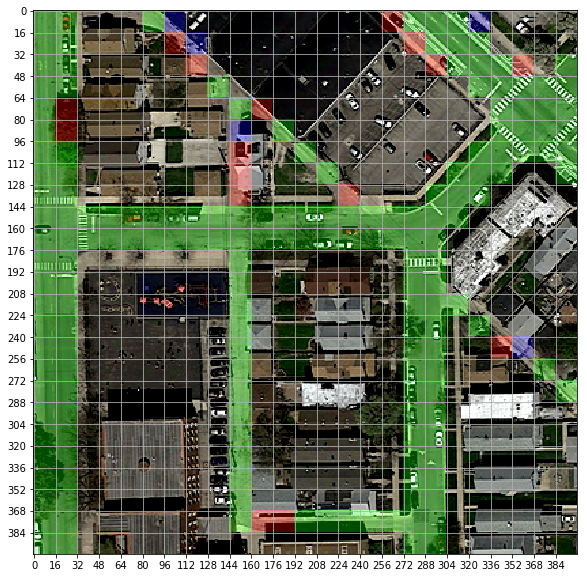

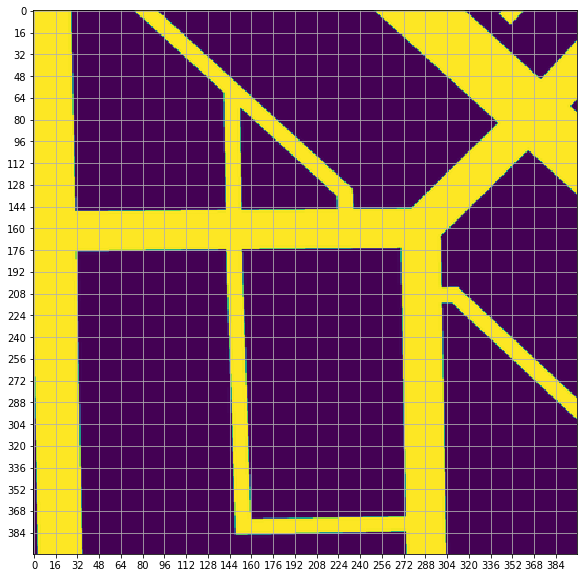

In [51]:
import itertools

def join_img(Y_patches, train):
    if train:
        step, img_size = PATCH_SIZE, IMG_SIZE
    else:
        step, img_size = PATCH_SIZE, TEST_IMG_SIZE
    
    Y = np.zeros((img_size, img_size))
    idx = 0
    for y in range(0, img_size - PATCH_SIZE + 1, step):
        for x in range(0, img_size - PATCH_SIZE + 1, step):
            Y[y:y+PATCH_SIZE, x:x+PATCH_SIZE] = Y_patches[idx, 1]
            idx += 1

    return Y


img_idx = 41
X_sample = X_train[img_idx]
patches_per_img = ((X_sample.shape[0] // PATCH_SIZE) ** 2)

gen = input_pipeline_test(X_sample[np.newaxis, ...], Y_train[img_idx:img_idx+1], X_sample.shape[0])
patches = list(itertools.islice(gen, 0, patches_per_img // BATCH_SIZE + 2))
# X_patches = np.concatenate(patches)
X_patches = np.concatenate([ x[0] for x in list(patches) ])
Y_patches_ref = np.concatenate([ x[1] for x in list(patches) ])
Y_patches = model.predict(X_patches[:patches_per_img])
Y_sample = join_img(Y_patches[:patches_per_img], X_sample.shape[0] == IMG_SIZE)
Y_sample_ref = join_img(Y_patches_ref[:patches_per_img], X_sample.shape[0] == IMG_SIZE)

# import itertools
# gen = input_pipeline_test(X_train[img_idx:img_idx+1], Y_train[img_idx:img_idx+1], IMG_SIZE)
# patches = list(itertools.islice(gen, 0, patches_per_img // BATCH_SIZE + 2))
# X_patches = np.concatenate([ x[0] for x in list(patches) ])
# Y_patches = np.concatenate([ x[1] for x in list(patches) ])
# Y_sample = join_img(Y_patches, True)

Y_sample = np.minimum(np.maximum(np.round(Y_sample[..., np.newaxis]), 0), 1)
Y_sample_ref = np.minimum(np.maximum(np.round(Y_sample_ref[..., np.newaxis]), 0), 1)
correct = Y_sample * Y_sample_ref
alpha = (1-Y_sample) * Y_sample_ref
beta = Y_sample * (1-Y_sample_ref)
colored = correct*np.array([0.,.3,0.]) + alpha*np.array([.3,0.,0.]) + beta*np.array([0.,0.,.3])
colored = np.minimum(X_sample + colored, 1)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
plt.imshow(colored);
loc = plticker.MultipleLocator(base=16)
ax.xaxis.set_major_locator(loc)
ax.yaxis.set_major_locator(loc)
plt.grid(which='major', axis='both', linestyle='-')

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
plt.imshow(Y_train[img_idx]);
loc = plticker.MultipleLocator(base=16)
ax.xaxis.set_major_locator(loc)
ax.yaxis.set_major_locator(loc)
plt.grid(which='major', axis='both', linestyle='-')